In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
df = pd.read_csv("data/tagged category data.csv", encoding = "ISO-8859-1")
df.head()
df2 = pd.read_csv("data/tagged category data.csv", encoding = "ISO-8859-1")
sentiment_df = pd.read_csv("data/sentiment annotation data.csv", encoding = "ISO-8859-1")
sentiment_df.set_index('review_id', inplace=True)

In [18]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
#no stop word
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [3]:
df['text'] = df['text'].map(lambda com : clean_text(com))

In [4]:
#stop word filter
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text_2(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [5]:
df['text'] = df['text'].map(lambda com : clean_text_2(com))

In [6]:
def extract_sentiment(category):  
    review_ids = []
    for i in range(len(df2[category])): #food
        if df2[category][i] == 1:
            review_ids.append(df2['review_id'][i])
    print(len(review_ids))

    drop_list = []
    for item in df2['review_id']:
        if item not in review_ids:
            drop_list.append(item)
    new_df = sentiment_df[['text','%s_pos'%category]]
    new_df.drop(drop_list, inplace = True)    
    return new_df

In [7]:
categories = ['food', 'ambience', 'service', 'price']
food_df = extract_sentiment(categories[0])
food_df.head()

372


,text,food_pos
review_id,,
yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1.0
fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1.0
G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1.0
8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill.Clearly they hav...,0.0
Z7wgXp98wYB57QdRY3HQ3w,Wow. So surprised at the one and two star revi...,1.0


In [8]:
food_df['text'] = food_df['text'].map(lambda com : clean_text(com))

In [9]:
from sklearn.utils import resample

def upsample(df):
    df.fillna(0,inplace = True)
    majority = int(df.iloc[:,1].values.sum())
    # Separate majority and minority classes
    df_majority = df[df.iloc[:,1]==1]
    df_minority = df[df.iloc[:,1]==0]
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=majority,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    upsampled = pd.concat([df_majority, df_minority_upsampled])
    return upsampled



In [10]:
ambience_df = extract_sentiment(categories[1])
ambience_df.head()

153


,text,ambience_pos
review_id,,
fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,0.0
G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1.0
Z7wgXp98wYB57QdRY3HQ3w,Wow. So surprised at the one and two star revi...,1.0
1wVA2-vQIuW_ClmXkDxqMQ,Great lunch today. Staff was very helpful in a...,1.0
6BnQwlxRn7ZuWdzninM9sQ,I love chinese food and I love mexican food. W...,0.0


In [11]:
ambience_df[ambience_df['ambience_pos'] == 1].sum()

text            Tracy dessert had a big name in Hong Kong and ...
ambience_pos                                                  125
dtype: object

In [12]:
ambience_df['text'] = ambience_df['text'].map(lambda com : clean_text(com))

In [13]:
service_df = extract_sentiment(categories[2])
service_df.head()

248


,text,service_pos
review_id,,
yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1.0
fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,0.0
8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill.Clearly they hav...,0.0
-I5umRTkhw15RqpKMl_o1Q,"Walked in around 4 on a Friday afternoon, we s...",0.0
Z7wgXp98wYB57QdRY3HQ3w,Wow. So surprised at the one and two star revi...,1.0


In [14]:
service_df['text'] = service_df['text'].map(lambda com : clean_text(com))

In [15]:
price_df = extract_sentiment(categories[3])
price_df.head()

116


,text,price_pos
review_id,,
yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1.0
fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1.0
G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,0.0
8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill.Clearly they hav...,0.0
kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...",1.0


In [16]:
price_df['text'] = price_df['text'].map(lambda com : clean_text(com))

In [115]:
# df_toxic = df.drop(['review_id', 'text','stars'], axis=1)
# counts = []
# categories = ['food', 'ambience', 'service', 'price']
# for i in categories:
#     counts.append((i, df_toxic[i].sum()))
# df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
# df_stats

# df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
# plt.title("Number of reviews per category")
# plt.ylabel('# of reviews', fontsize=12)
# plt.xlabel('category', fontsize=12)

In [17]:
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Dropout
from keras.layers import Flatten,Conv1D,LSTM, MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [18]:
food_balanced = upsample(food_df)
ambience_balanced = upsample(ambience_df)
service_balanced = upsample(service_df)
price_balanced = upsample(price_df)

In [338]:
# def preprocess_text(sen):
#     # Removing html tags
#     sentence = remove_tags(sen)

#     # Remove punctuations and numbers
#     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

#     # Single character removal
#     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

#     # Removing multiple spaces
#     sentence = re.sub(r'\s+', ' ', sentence)

#     return sentence
# TAG_RE = re.compile(r'<[^>]+>')

# def remove_tags(text):
#     return TAG_RE.sub('', text)



In [121]:
X = []
sentences = list(price_balanced['text'])
for sen in sentences:
    X.append(sen)
sentiments =price_balanced.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, sentiments, test_size=0.2, random_state=45)

In [122]:
#API embedding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [123]:
#pretraind embeddings
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('embeddings/glove.6B/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [78]:
#word embedding from document

#max_length = max([len(s.split()) for s in X_train])


word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(word_tokenizer.word_index) + 1
#embedded_sentences = word_tokenizer.texts_to_sequences(X_train)

# word_count = lambda sentence: len(word_tokenize(sentence))
# longest_sentence = max(X_train, key=word_count)
# max_length = len(word_tokenize(longest_sentence))


X_train = pad_sequences(X_train,30, padding='post')
X_test = pad_sequences(X_test, 30, padding='post')


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 30, 200)           451200    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 23, 32)            51232     
_________________________________________________________________
flatten_25 (Flatten)         (None, 736)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 737       
Total params: 503,169
Trainable params: 503,169
Non-trainable params: 0
_________________________________________________________________
None
Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 11s 114ms/step - loss: 0.6913 - acc: 0.5625 - f1_m: 0.6163 - precision_m: 0.5962 - recall_m: 0.6594 - val_loss: 0.6747 - val_acc: 0.7600 - val_f1

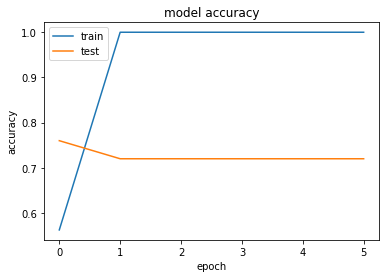

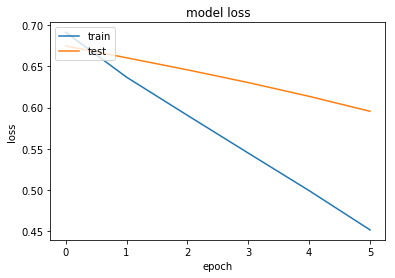

In [89]:
#CNN
# define model
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=30))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(256, activation='relu', input_shape=(n_cols,)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())
# fit network
test_model(model)





Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 30, 200)           451200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 619,777
Trainable params: 619,777
Non-trainable params: 0
_________________________________________________________________
None
Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 9s 99ms/step - loss: 0.6934 - acc: 0.5208 - f1_m: 0.5194 - precision_m: 0.5008 - recall_m: 0.5814 - val_loss: 0.6885 - val_acc: 0.6400 - val_f1_m: 0.6400 - val_precision_m: 0.8000 - val_recall_m: 0.5333
Epoch 2/6
96/96 [==============================] - 1s 10ms/step - loss: 0.

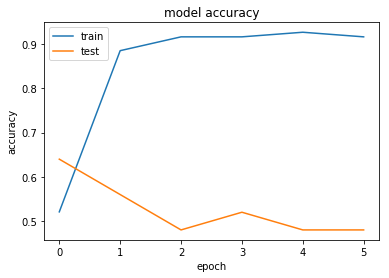

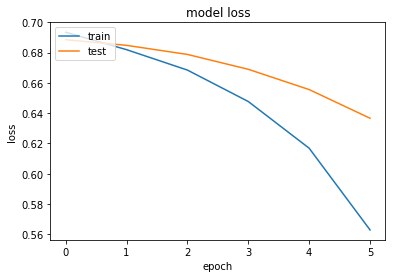

In [88]:
# LSTM   define model
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=30))
# model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(256, activation='relu', input_shape=(n_cols,)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(LSTM(128))
# model.add(Dense(10, activation='relu'))
#model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())
# fit network
test_model(model)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 30, 200)           451200    
_________________________________________________________________
flatten_23 (Flatten)         (None, 6000)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6001      
Total params: 457,201
Trainable params: 457,201
Non-trainable params: 0
_________________________________________________________________
None
Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 3s 28ms/step - loss: 0.6942 - acc: 0.4583 - f1_m: 0.5392 - precision_m: 0.5279 - recall_m: 0.5658 - val_loss: 0.6799 - val_acc: 0.6800 - val_f1_m: 0.6923 - val_precision_m: 0.8182 - val_recall_m: 0.6000
Epoch 2/6
96/96 [==============================] - 0s 1ms/step - loss: 0.6

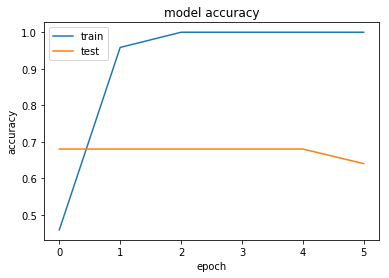

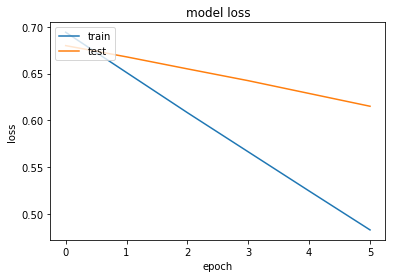

In [85]:
#simple
# define model
model = Sequential()
model.add(Embedding(vocab_size, 200, input_length=30))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(256, activation='relu', input_shape=(n_cols,)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
print(model.summary())
# fit network
test_model(model)


In [ ]:
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

In [120]:
# from numpy import array
# from numpy import asarray
# from numpy import zeros

# embeddings_dictionary = dict()
# glove_file = open('embeddings/glove.6B/glove.6B.200d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary [word] = vector_dimensions
# glove_file.close()

# embedding_matrix = zeros((vocab_size, 200))
# for word, index in tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector

In [131]:
def test_model(model):
    history = model.fit(X_train, y_train, batch_size=64, epochs=6, verbose=1, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=0)
    
    #loss, accuracy, f1_score, precision, recall
    print("loss {} accuracy {} f1 {} precision {} recall {}".format(*score), "Test Score:", score[0], "Test Accuracy:", score[1])



    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
#     y_pred = model.predict(X_test)#, verbose=1)
#     y_pred_bool = np.argmax(y_pred, axis=1)

#     print(classification_report(y_test, y_pred_bool))

#     cm = confusion_matrix(y_test,y_pred_bool)
#     print(cm)
#     print(y_pred)
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     print ('AUC-'+'=',roc_auc)

In [28]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 50, 200)           451200    
_________________________________________________________________
flatten_33 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 10001     
Total params: 461,201
Trainable params: 10,001
Non-trainable params: 451,200
_________________________________________________________________
None
Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 9s 92ms/step - loss: 0.7459 - acc: 0.5000 - f1_m: 0.3605 - precision_m: 0.7167 - recall_m: 0.3111 - val_loss: 0.7099 - val_acc: 0.5200 - val_f1_m: 0.3333 - val_precision_m: 1.0000 - val_recall_m: 0.2000
Epoch 2/6
96/96 [==============================] - 0s 716us/step - lo

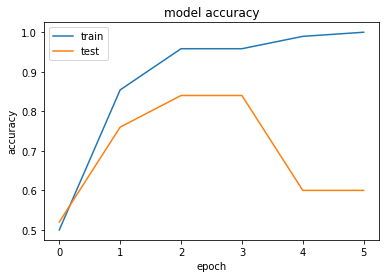

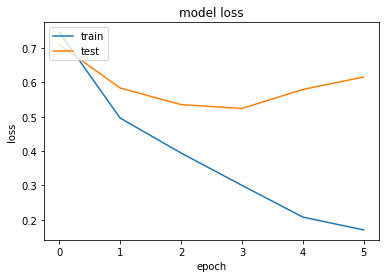

In [132]:
#Simple
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=50 , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

print(model.summary())
test_model(model)

The plots here show that our neural networks is clearly overfitting.

Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 9s 94ms/step - loss: 0.7210 - acc: 0.5625 - f1_m: 0.3918 - precision_m: 0.7700 - recall_m: 0.4552 - val_loss: 0.6360 - val_acc: 0.5200 - val_f1_m: 0.5000 - val_precision_m: 0.6667 - val_recall_m: 0.4000
Epoch 2/6
96/96 [==============================] - 0s 3ms/step - loss: 0.4692 - acc: 0.8958 - f1_m: 0.8709 - precision_m: 0.8250 - recall_m: 0.9559 - val_loss: 0.5248 - val_acc: 0.8000 - val_f1_m: 0.8571 - val_precision_m: 0.7500 - val_recall_m: 1.0000
Epoch 3/6
96/96 [==============================] - 0s 4ms/step - loss: 0.3306 - acc: 0.9583 - f1_m: 0.9667 - precision_m: 0.9375 - recall_m: 1.0000 - val_loss: 0.5214 - val_acc: 0.7600 - val_f1_m: 0.7857 - val_precision_m: 0.8462 - val_recall_m: 0.7333
Epoch 4/6
96/96 [==============================] - 0s 3ms/step - loss: 0.2341 - acc: 1.0000 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000 - val_loss: 0.4912 - val_acc: 0.7600 - val_f1_m:

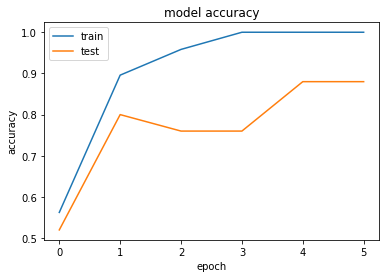

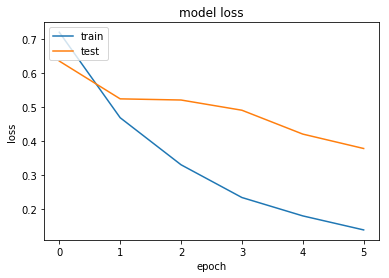

In [133]:
#try CNN
model = Sequential()

embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=50 , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
test_model(model)

Train on 96 samples, validate on 25 samples
Epoch 1/6
96/96 [==============================] - 11s 115ms/step - loss: 0.6954 - acc: 0.5208 - f1_m: 0.2961 - precision_m: 0.7500 - recall_m: 0.2571 - val_loss: 0.7264 - val_acc: 0.4400 - val_f1_m: 0.1250 - val_precision_m: 1.0000 - val_recall_m: 0.0667
Epoch 2/6
96/96 [==============================] - 1s 15ms/step - loss: 0.6451 - acc: 0.6042 - f1_m: 0.3579 - precision_m: 0.9286 - recall_m: 0.2218 - val_loss: 0.6933 - val_acc: 0.4800 - val_f1_m: 0.3158 - val_precision_m: 0.7500 - val_recall_m: 0.2000
Epoch 3/6
96/96 [==============================] - 1s 12ms/step - loss: 0.6111 - acc: 0.8125 - f1_m: 0.7875 - precision_m: 0.9643 - recall_m: 0.6804 - val_loss: 0.6820 - val_acc: 0.6000 - val_f1_m: 0.5833 - val_precision_m: 0.7778 - val_recall_m: 0.4667
Epoch 4/6
96/96 [==============================] - 1s 14ms/step - loss: 0.5845 - acc: 0.8229 - f1_m: 0.7842 - precision_m: 0.7812 - recall_m: 0.8684 - val_loss: 0.6875 - val_acc: 0.5200 - val_

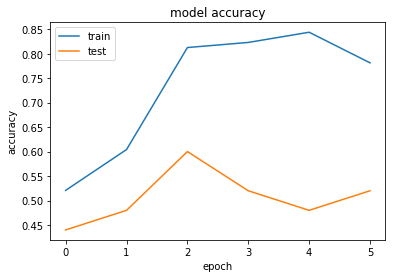

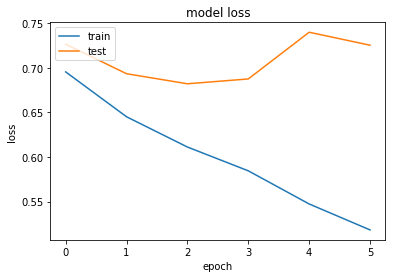

In [134]:
#RNN, LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=50 , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
test_model(model)

In [87]:
#create word embeddings
from nltk.tokenize import word_tokenize

# #find total number of words in our corpus
# all_words = []
# for sent in food_df['text']:
#     tokenize_word = word_tokenize(sent)
#     for word in tokenize_word:
#         all_words.append(word)
# #filter duplicate words
# unique_words = set(all_words)
# vocab_length = len(unique_words)
# #set vocab_length to 4600 

# #convert text to numbers by using the one_hot function from the keras.preprocessing.text library. 
# embedded_sentences = [one_hot(sent, vocab_length) for sent in food_df['text']]


word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(food_df['text'])
vocab_length = len(word_tokenizer.word_index) + 1
embedded_sentences = word_tokenizer.texts_to_sequences(food_df['text'])

In [65]:
#The embedding layer expects sentences to be of equal size. We find the largest sentence and pad the sentences with 0
# word_count = lambda sentence: len(word_tokenize(sentence))
# longest_sentence = max(food_df['text'], key=word_count)
# length_long_sentence = len(word_tokenize(longest_sentence))
# padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
# print(padded_sentences)
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(food_df['text'], key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')

[[ 130   13   11 ...    0    0    0]
 [   3   47   33 ...    0    0    0]
 [1239  194   26 ...    0    0    0]
 ...
 [   1   36   10 ...    0    0    0]
 [   1  183    3 ...    0    0    0]
 [   3   17   84 ...    0    0    0]]


In [70]:
model = Sequential()
model.add(Embedding(vocab_length, 30, input_length=length_long_sentence))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 912, 30)           137550    
_________________________________________________________________
flatten_7 (Flatten)          (None, 27360)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 27361     
Total params: 164,911
Trainable params: 164,911
Non-trainable params: 0
_________________________________________________________________
None


In [71]:



model.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f%f' % (accuracy*100))

Epoch 1/20
297/297 [==============================] - 10s 35ms/step - loss: 0.5295 - mse: 0.1619 - accuracy: 0.7744
Epoch 2/20
297/297 [==============================] - 2s 6ms/step - loss: 0.4597 - mse: 0.1410 - accuracy: 0.8316
Epoch 3/20
297/297 [==============================] - 2s 7ms/step - loss: 0.4322 - mse: 0.1326 - accuracy: 0.8316
Epoch 4/20
297/297 [==============================] - 2s 7ms/step - loss: 0.4078 - mse: 0.1248 - accuracy: 0.8350
Epoch 5/20
297/297 [==============================] - 2s 6ms/step - loss: 0.3889 - mse: 0.1198 - accuracy: 0.8384
Epoch 6/20
297/297 [==============================] - 2s 7ms/step - loss: 0.3577 - mse: 0.1037 - accuracy: 0.8552
Epoch 7/20
297/297 [==============================] - 2s 8ms/step - loss: 0.3174 - mse: 0.0933 - accuracy: 0.8552
Epoch 8/20
297/297 [==============================] - 2s 6ms/step - loss: 0.2795 - mse: 0.0809 - accuracy: 0.8788
Epoch 9/20
297/297 [==============================] - 2s 6ms/step - loss: 0.2416 - mse

ValueError: too many values to unpack (expected 2)